In [8]:
import os
import sys
from datetime import datetime

import gym
from gym import wrappers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')

In [7]:
print('Action Space: ', env.action_space)
print('Observation Space: ', env.observation_space)
print('Obs Space (high): ', env.observation_space.high)
print('Obs Space (low): ', env.observation_space.low)

Action Space:  Discrete(2)
Observation Space:  Box(4,)
Obs Space (high):  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Obs Space (low):  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [9]:
def build_state(features):
    return (''.join(map(lambda feature: str(int(feature)), features)))

In [10]:
def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

In [20]:
class FeatureTransformer:
    def __init__(self):
        self.cart_position_bins = np.linspace(-4.8, 4.8, 9)
        self.cart_velocity_bins = np.linspace(-2, 2, 9)
        self.pole_angle_bins = np.linspace(-4.2, 4.2, 9)
        self.pole_velocity_bins = np.linspace(-4, 4, 9)
        
    def transform(self, obs):
        cart_pos, cart_vel, pole_angle, pole_vel = obs
        
        return build_state([to_bin(cart_pos, self.cart_position_bins),
                            to_bin(cart_vel, self.cart_velocity_bins),
                            to_bin(pole_angle, self.pole_angle_bins),
                            to_bin(pole_vel, self.pole_velocity_bins)])

In [45]:
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.feature_transformer = feature_transformer
        
        num_states = 10**env.observation_space.shape[0]
        num_actions = env.action_space.n
        self.Q = np.random.uniform(low=-1, high=1, size=(num_states, num_actions))
        
    def predict(self, state):
        x = self.feature_transformer.transform(state)
        return self.Q[int(x)]
    
    def update(self, state, action, G):
        x = self.feature_transformer.transform(state)
        self.Q[int(x),action] += 10e-3*(G - self.Q[int(x), action])
        
    def sample_action(self, state, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            prediction = self.predict(state)
            return np.argmax(prediction)

In [46]:
def play_one(model, eps, gamma):
    obs = env.reset()
    done = False
    total_R = 0
    iters = 0
    
    while not done and iters < 2000:
        action = model.sample_action(obs, eps)
        prev_obs = obs
        obs, reward, done, _ = env.step(action)
        
        total_R += reward
        
        if done and iters < 199:
            reward = -300
            
        G = reward + gamma * np.max(model.predict(obs))
        
        model.update(prev_obs, action, G)
        
        iters += 1
    
    return total_R

In [47]:
def plot_running_avg(rewards):
    N = len(rewards)
    running_avg = np.empty(N)
    
    for t in range(N):
        running_avg[t] = rewards[max(0, t-100):t+1].mean()
    
    plt.plot(running_avg)
    plt.title("Running Average Score")
    plt.show()

In [48]:
feat_transformer = FeatureTransformer()
model = Model(env, feat_transformer)
gamma = 0.99

In [56]:
N = 5000
total_R = np.empty(N)

Episode: 0 	Total Reward: 12.0 	 Epsilon: 1.0
Episode: 100 	Total Reward: 200.0 	 Epsilon: 0.09950371902099892
Episode: 200 	Total Reward: 200.0 	 Epsilon: 0.07053456158585983
Episode: 300 	Total Reward: 200.0 	 Epsilon: 0.0576390417704235
Episode: 400 	Total Reward: 200.0 	 Epsilon: 0.04993761694389223
Episode: 500 	Total Reward: 200.0 	 Epsilon: 0.04467670516087703
Episode: 600 	Total Reward: 200.0 	 Epsilon: 0.04079085082240021
Episode: 700 	Total Reward: 200.0 	 Epsilon: 0.0377694787300249
Episode: 800 	Total Reward: 200.0 	 Epsilon: 0.03533326266687867
Episode: 900 	Total Reward: 65.0 	 Epsilon: 0.03331483023263848
Episode: 1000 	Total Reward: 138.0 	 Epsilon: 0.0316069770620507
Episode: 1100 	Total Reward: 200.0 	 Epsilon: 0.03013743873394561
Episode: 1200 	Total Reward: 200.0 	 Epsilon: 0.028855492841238062
Episode: 1300 	Total Reward: 50.0 	 Epsilon: 0.027724348650071385
Episode: 1400 	Total Reward: 175.0 	 Epsilon: 0.02671658425726324
Episode: 1500 	Total Reward: 200.0 	 Epsil

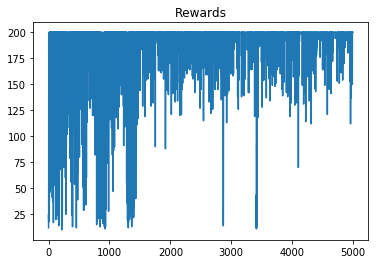

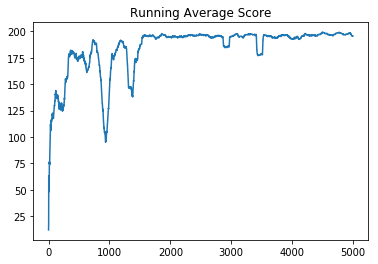

In [57]:
for i in range(N):
    eps = 1.0/np.sqrt(i+1)
    total_r = play_one(model, eps, gamma)
    total_R[i] = total_r
    
    if i % 100 == 0:
        print('Episode: {} \tTotal Reward: {} \t Epsilon: {}'.format(i,
                                                                     total_r,
                                                                     eps))

print('Average reward for last 100 episodes: ', total_R[-100:].mean())
print('Total steps: ', total_R.sum())

plt.plot(total_R)
plt.title('Rewards')
plt.show()

plot_running_avg(total_R)